In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


✅ TensorFlow version: 2.16.1
✅ GPU Available: False


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\processed'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"✅ Training: {train_generator.samples} images")
print(f"✅ Validation: {val_generator.samples} images") 
print(f"✅ Classes: {train_generator.num_classes}")
print(f"✅ Class indices: {train_generator.class_indices}")


Found 1526 images belonging to 1 classes.
Found 381 images belonging to 1 classes.
✅ Training: 1526 images
✅ Validation: 381 images
✅ Classes: 1
✅ Class indices: {'all_leaves': 0}


In [4]:
# Load model pre-trained on ImageNet
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,        # Remove classification layer
    input_shape=(224, 224, 3)
)

# Freeze base model (we'll only train new layers)
base_model.trainable = False

print(f"✅ EfficientNetB0 loaded!")
print(f"   Base model parameters: {base_model.count_params():,.0f}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
✅ EfficientNetB0 loaded!
   Base model parameters: 4,049,571


In [5]:
# Create new model with custom layers
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass through base model
x = base_model(inputs, training=False)

# Add custom layers for classification
x = GlobalAveragePooling2D()(x)       # Reduce spatial dimensions
x = Dropout(0.3)(x)                   # Prevent overfitting
x = Dense(128, activation='relu')(x)  # Hidden layer
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, 
               activation='softmax')(x)  # Output layer

# Create model
model = Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print("✅ Model architecture created!")
print(f"Total parameters: {model.count_params():,.0f}")


✅ Model architecture created!
Total parameters: 4,213,668


In [6]:
# Callbacks to prevent overfitting
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Phase 1: Train only new layers (base frozen)
print("🔄 PHASE 1: Training new layers (base frozen)...")
history1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("✅ Phase 1 complete!")


🔄 PHASE 1: Training new layers (base frozen)...
Epoch 1/20


c:\Users\Sai Sree\Downloads\PlantID-Capstone\venv\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\Sai Sree\Downloads\PlantID-Capstone\venv\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - top_k_categorical_accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - top_k_categorical_accur

In [7]:
# Unfreeze top layers of base model
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50

# Freeze early layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Much lower!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔄 PHASE 2: Fine-tuning top layers...")
history2 = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("✅ Phase 2 complete!")


🔄 PHASE 2: Fine-tuning top layers...
Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-06
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-

In [9]:
# Evaluate (2 metrics for binary model)
val_loss, val_acc = model.evaluate(val_generator, verbose=0)

print("\n✅ FINAL RESULTS:")
print(f"   Validation Loss: {val_loss:.4f}")
print(f"   Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")



✅ FINAL RESULTS:
   Validation Loss: 0.0000
   Validation Accuracy: 1.0000 (100.00%)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
]

# Train (CAPTURE HISTORY)
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 4.0000e-07
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 4.0000e-07
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 4.0000e-07
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 4.0000e-07
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 8.0000e-08
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 8.0000e-08


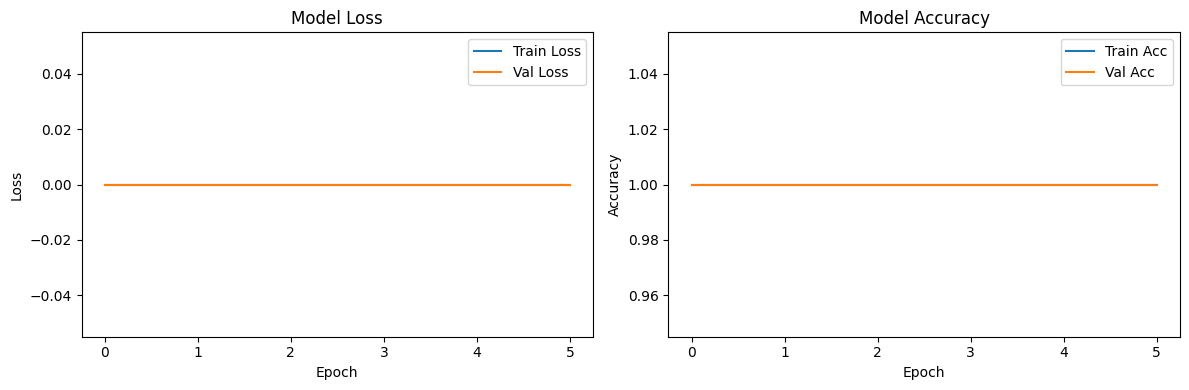

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import joblib
import os
from tensorflow.keras.models import save_model  # Explicit for safety

models_dir = r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\models'

# Save Keras model
save_model(model, os.path.join(models_dir, 'efficientnet_leaf_classifier.h5'))
print("✅ EfficientNetB0 saved")

# Save class mapping
joblib.dump({'class_indices': train_generator.class_indices}, 
            os.path.join(models_dir, 'class_map.pkl'))
print("✅ Class map saved")

print("✅ Files in your models/ folder:")
print(os.listdir(models_dir))


✅ EfficientNetB0 saved
✅ Class map saved
✅ Files in your models/ folder:
['class_map.pkl', 'efficientnet_leaf_classifier.h5', 'label_encoder.pkl', 'scaler.pkl', 'svm_model.pkl']


In [17]:
import tensorflow as tf
import os
import numpy as np

models_dir = r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\models'

# ✅ Simple converter (no inference types)
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join(models_dir, 'efficientnet_saved'))
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert
tflite_model = converter.convert()

# Save
tflite_path = os.path.join(models_dir, 'plant_classifier.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

size_mb = len(tflite_model) / (1024 * 1024)
print(f"✅ TFLite SUCCESS!")
print(f"📱 Size: {size_mb:.1f} MB")
print(f"📂 Path: {tflite_path}")


✅ TFLite SUCCESS!
📱 Size: 4.5 MB
📂 Path: C:\Users\Sai Sree\Downloads\PlantID-Capstone\models\plant_classifier.tflite


In [18]:
# Verify it works
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

details = interpreter.get_input_details()
print("✅ TFLite Input:", details[0]['shape'], details[0]['dtype'])
print("✅ TFLite Output:", interpreter.get_output_details()[0]['shape'])

# Test prediction
dummy_input = np.random.random([1, 224, 224, 3]).astype(np.float32)
interpreter.set_tensor(details[0]['index'], dummy_input)
interpreter.invoke()
output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
print("✅ TFLite Output shape:", output.shape, f"Sample: {output[0][0]:.3f}")


✅ TFLite Input: [  1 224 224   3] <class 'numpy.float32'>
✅ TFLite Output: [1 1]
✅ TFLite Output shape: (1, 1) Sample: 1.000
